In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import seaborn           as sns
import os
import torch
import json

from libraries.model   import Helmholtz_free_energy_function, make_predictions, GCNN, compute_coefficients
from libraries.dataset import load_atomic_masses, include_temperatures, create_predictions_dataset, standardize_dataset_from_keys

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()

In this notebook you are able to load an use a pre-trained model for predicting the lattice contribution to the free-energy over an input database. The model, $GCNN$, predicts the lattice contribution to the free-energy, $F_v(m, T) = GCNN(m, T)$, for material $m$ at temperature $T$. Then, knowing the ground-state energy of material $m$, $E_0 (m)$ (typically estimated from DFT), the Helmholtz free-energy reads from:

\begin{equation}
    F(m, T) = E_0 (m) + F_v(m, T)
\end{equation}

Importantly, this approach disregards any other contribution to the free-energy that just vibrational (e.g., metallic materials should be avoided).

The baseline pretrained model has been trained in the 100 to 700 K temperature range, thus it is recommended to make predictions within the 200 to 600 K range, in order to avoid the misbehaviour of $C_p$ at high temperature.

We implemented a tool which allows estimating the quality of the predicted free energy regarding 1) the chemistry of the target material and 2) the temperature at which the prediction is made. This approach is valid for any other input model, as it directly checks the proximity of the hyper-representation that the GCNN creates for the target material and this from any known prediction.

Ferromagnetic transitions are estimated based on pure geometrical reasons, predicted as any transition involving a non-centrosymmmetric space group.

The input database should contain on each folder a POSCAR file with the structure, a file name EPA with the energy per atom in eV/atom (typically from DFT) and, optionally, a file name LTC with the lattice thermal conductivity in W/mK. It should be strucuture like:

**database**  
&nbsp;**material-1**  
&nbsp;&nbsp;&nbsp;**polymorph-1**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- POSCAR  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- EPA  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- LTC (opt)  
&nbsp;&nbsp;&nbsp;**polymorph-2**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- POSCAR  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- EPA  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- LTC (opt)  
&nbsp;&nbsp;&nbsp;**polymorph-...**  
&nbsp;**material-2**  
&nbsp;&nbsp;&nbsp;**polymorph-...**  
&nbsp;**material-...**  

# Define parameters

In [2]:
model_folder    = 'model'  # Pre-trained model and dataset parameters
data_folder     = 'example-data'  # Example coefficients and labels of the target database
output_folder   = 'output'  # Output files and figures
input_folder    = 'input'  # General files (e.g., atomic masses information)
target_database = 'target_dataset'  # Target database

# Whether to plot the harmonic extrapolations of Fv (very time-consuming) or not
plot_extrapolations = False

# Defining the range of temperatures
Ti = 300
Tf = 600
dT = 50
temperatures = np.arange(Ti, Tf+dT, dT)  # Temperatures for prediction of free-energies

# Loading dictionary of atomic masses
atomic_masses = load_atomic_masses(f'{input_folder}/atomic_masses.dat')

# Perform predictions

For the sake of optimization, we first predict all free-energies in the target database. In order to do that, we read the parameters needed for standardizing the target dataset, load the pre-trained model, perform the predictions and smooth those with a fitting to a fourth-order polynomial (with respect to temperature).

In [3]:
if os.path.exists(f'{data_folder}/coefficients.txt') and os.path.exists(f'{data_folder}/labels.txt'):
    coefficients = np.loadtxt(f'{data_folder}/coefficients.txt')
    labels = [f'{label[0]} {label[1]}' for label in np.loadtxt(f'{data_folder}/labels.txt', dtype=str)]
else:
    # Load the data from the JSON file
    with open(f'{model_folder}/standardized_parameters.json', 'r') as json_file:
        numpy_dict = json.load(json_file)

    # Convert NumPy arrays back to PyTorch tensors
    standardized_parameters = {}
    for key, value in numpy_dict.items():
        try:
            standardized_parameters[key] = torch.tensor(value)
        except:
            standardized_parameters[key] = value

    # Load reference dataset for uncertainty estimation
    reference_dataset = torch.load(f'{model_folder}/ref_std_dataset.pt', weights_only=False)

    # Create dataset for predictions
    dataset = create_predictions_dataset(target_database)
    torch.save(dataset, f'{data_folder}/dataset.pt')
    labels = [graph.label for graph in dataset]

    # Standardize properties
    std_dataset = standardize_dataset_from_keys(dataset, standardized_parameters)

    # Free-up CUDA
    del dataset

    # Load Graph Neural Network model (making room for temperature as node attribute) to device
    # Dropout for initializing the model, not used at all while predicting
    model = GCNN(features_channels=dataset[0].num_node_features+1,
                 pdropout=0).to(device)

    # Load and evaluate Graph Neural Network model
    model.load_state_dict(torch.load(f'{model_folder}/model.pt', map_location=torch.device(device)))
    model.eval()

    # Include temperatures
    std_dataset_w_temp = include_temperatures(std_dataset, temperatures, standardized_parameters)

    # Free-up CUDA
    del std_dataset

    # Compute predictions and corresponding uncertainties
    shot_predictions, shot_uncertainties = make_predictions(reference_dataset, std_dataset_w_temp, model, standardized_parameters)

    # Free-up CUDA
    del std_dataset_w_temp, reference_dataset

    # Computing the coefficients and uncertainties from fitting
    coefficients = compute_coefficients(temperatures, shot_predictions, shot_uncertainties, s=0.5)

    np.savetxt(f'{data_folder}/coefficients.txt', coefficients)
    np.savetxt(f'{data_folder}/labels.txt',       labels, fmt='%s')

# Compute phase transitions

Then, we have already computed the free-energies for each material in the intended temperature range and also the parameters of the fourth-order polynomial which smooths the predictions. With that information, we can look for phase transitions for each materials presenting at least two polymorphs in the target dataset and, for those, extract transition temperature, entropy change or whether this is or not a ferroelectric transition.

In [4]:
# Ordering by families
indexes       = np.argsort(labels)  # This way we put all the polymorphs from a same material together
labels        = np.array(labels)[indexes]
coefficients  = coefficients[:, indexes]

# Separating compounds and polymorphes
compounds, polymorphs = zip(*(line.split() for line in labels))

# Reading ground state energies (energy per atom)
# From eV/atom to meV/atom
gs_energies = [float(np.loadtxt(f'{target_database}/{comp}/{poly}/EPA')) * 1e3 for comp, poly in zip(compounds, polymorphs)]

# Reading conductivities (lattice thermal conductivities)
# In W/mK
conductivities = [float(np.loadtxt(f'{target_database}/{comp}/{poly}/LTC'))
                  if os.path.isfile(f'{target_database}/{comp}/{poly}/LTC') else np.nan for comp, poly in zip(compounds, polymorphs)]

# Reading centrosymmetris (1 is centrosymmetric, 0 is not)
centrosymmetries_list = np.array([np.loadtxt(f'{target_database}/{comp}/{poly}/is_centrosymmetric', dtype=int) for comp, poly in zip(compounds, polymorphs)])
space_groups_list     = np.array([np.loadtxt(f'{target_database}/{comp}/{poly}/space_group', dtype=str) for comp, poly in zip(compounds, polymorphs)])

# Unique compounds (not considering polymorphes)
unique_compounds, unique_counts = np.unique(compounds, return_counts=True)
unique_indexes = np.append([0], np.cumsum(unique_counts))  # So it starts with 0

In [5]:
# Initializing files with data
stable_transition_phases   = []
unstable_transition_phases = []
for i, compound in enumerate(unique_compounds):
    # Getting corresponding predictions
    index1 = unique_indexes[i]
    index2 = unique_indexes[i+1]

    static_energies          = gs_energies[index1:index2]
    lattice_conductivities   = conductivities[index1:index2]
    centrosymmetries         = centrosymmetries_list[index1:index2]
    space_groups             = space_groups_list[index1:index2]
    vibrational_coefficients = coefficients[:, index1:index2]

    n_polymorphs = index2 - index1
    if n_polymorphs > 1:
        print(compound)
        if plot_extrapolations:
            fig = plt.figure(figsize=(5, 5))

        free_energies = np.array([
            static_energies[k] + Helmholtz_free_energy_function(temperatures, *vibrational_coefficients[:, k])
            for k in range(n_polymorphs)
        ])

        for k in range(n_polymorphs):
            _beta_1         = vibrational_coefficients[:, k]
            static_energy_1 = static_energies[k]
            LTC_1           = lattice_conductivities[k]
            is_cts_1        = centrosymmetries[k]
            space_group_1   = space_groups[k]
            free_energies_1 = free_energies[k]

            # Plotting
            if plot_extrapolations:
                # Temperature range for plotting
                temperatures_plot = np.arange(Ti, Tf+dT, 0.1)

                # Smooth Gibbs energy for plotting
                gibbs_energy_plot = static_energy_1 + Helmholtz_free_energy_function(temperatures_plot, *_beta_1)
                plt.plot(temperatures_plot, gibbs_energy_plot, label=space_group_1)

            # Looking for phase transitions
            for m in np.arange(k+1, n_polymorphs):
                _beta_2         = vibrational_coefficients[:, m]
                static_energy_2 = static_energies[m]
                LTC_2           = lattice_conductivities[m]
                is_cts_2        = centrosymmetries[m]
                space_group_2   = space_groups[m]
                free_energies_2 = free_energies[m]

                # Computing the entropy change provoked by the transition
                d_E0 = static_energy_2 - static_energy_1
                d_alpha, d_beta, d_gamma = _beta_2 - _beta_1
                
                # We scaled parameters for fitting, so now we re-scale them
                d_beta  *= 1e-5
                d_gamma *= 1e-10
                
                # Two possible transition temperatures
                temp_root_1 = (-d_beta + np.sqrt(d_beta**2 - 4 * (d_E0 + d_alpha) * d_gamma)) / (2 * d_gamma)
                temp_root_2 = (-d_beta - np.sqrt(d_beta**2 - 4 * (d_E0 + d_alpha) * d_gamma)) / (2 * d_gamma)

                # Filter valid transition within the temperature range of interest
                c_valid_temperatures = [x for x in [np.sqrt(temp_root_1), np.sqrt(temp_root_2)] if Ti < x < Tf]

                # Determine if there is any transition within the temperature interval
                if not len(c_valid_temperatures):  # There is not a transition between these polymorphs
                    continue
                elif len(c_valid_temperatures) > 1:
                    print(f'Warning: {len(c_valid_temperatures)} transitions within this interval')

                # Get the expected critical temperature and free energy
                c_temperature = np.min(c_valid_temperatures)

                # Compute free energy and slope changes 
                c_free_energy = static_energy_1 + Helmholtz_free_energy_function(c_temperature, *_beta_1)
                d_slope       = c_temperature * np.abs(2 * d_beta + 4 * d_gamma * c_temperature**2)
                
                # Read atomic information for entropy change estimation
                with open(f'{target_database}/{compound}/{polymorphs[index1+k]}/POSCAR', 'r') as POSCAR_file:
                    POSCAR_lines = POSCAR_file.readlines()
                composition   = POSCAR_lines[5].split()
                concentration = np.array(POSCAR_lines[6].split(), dtype=float)

                # Get atomic mass involved in the transition
                total_mass = sum(float(atomic_masses[el]) * conc for el, conc in zip(composition, concentration))

                # Compute entropy change, from meV/atomK to J/kgK (1e3 as g goes to kg)
                c_entropy   = d_slope * 6.022 * 1.6 * 1e4 * concentration.sum() / total_mass

                # Check which has lower energy at lower temperature
                c_free_energy_1 = static_energy_1 + Helmholtz_free_energy_function(c_temperature-5, *_beta_1)
                c_free_energy_2 = static_energy_2 + Helmholtz_free_energy_function(c_temperature-5, *_beta_2)

                first_polymorph, last_polymorph = (space_group_1, space_group_2) if c_free_energy_1 < c_free_energy_2 else (space_group_2, space_group_1)
                label = f'{first_polymorph} -> {last_polymorph} ({c_temperature:.2f}K, {c_entropy:.2f} J/kgK)'
                print(label)
                
                if plot_extrapolations:
                    plt.plot(c_temperature, c_free_energy, 'o', label=label)

                # 0, 1, 2 if none, one or both are centrosymmetric, respectively
                centrosymmetric = is_cts_1 + is_cts_2
                
                # Get lattice thermal conductivity change
                
                # Divide by the centrysymmetric (nonpolar) polymorph LTC
                LTC_change = None
                if centrosymmetric == 1:
                    if is_cts_1:
                        LTC_change = np.abs(LTC_2 - LTC_1) / LTC_1
                    elif is_cts_2:
                        LTC_change = np.abs(LTC_2 - LTC_1) / LTC_2

                # Appending information (compound name, involved phases in order,
                # temperature of transition, entropy change involved in the transition,
                # whether a non-centrosymmetric phase is involved or not, and lattice
                # thermal conductivity change)
                transition_data = {'compound': compound, 'polymorph-1': first_polymorph, 'polymorph-2': last_polymorph,
                                   'transition-temperature': c_temperature, 'entropy-change': c_entropy,
                                   'centrosymmetry': centrosymmetric, 'conductivity-change': LTC_change}

                min_vib_energy = min(
                    static_energies[j] + Helmholtz_free_energy_function(c_temperature, *vibrational_coefficients[:, j])
                    for j in range(n_polymorphs)
                )

                if np.isclose(c_free_energy, min_vib_energy):
                    stable_transition_phases.append(transition_data)
                else:
                    unstable_transition_phases.append(transition_data)

        if plot_extrapolations:
            plt.title(compound)
            plt.xlabel('$T$ (K)')
            plt.ylabel(r'$F_{v}$ (meV/atom)')
            plt.legend(loc=(1.05, 0.5))
            plt.savefig(f'{model_folder}/{compound}.eps', dpi=50, bbox_inches='tight')
            plt.show()

Ag(CO)2
Ag10Te4Br3
Ag2B8O13
P2_1 -> P2_1/c (544.02K, 42.17 J/kgK)
Ag2HgI4
Ag2Mo2O7
Ag2PS3
Ag2S
P2_1/m -> P2_1 (577.70K, 62.01 J/kgK)
Ag2SO4
Ag2Se
Ag2WO4
Pnnm -> Pnn2 (422.57K, 19.84 J/kgK)
Ag3AsS3
Ag3AsSe3
Ag3SI
Ag3SbS3
AgAsS2
R-3 -> C2/c (549.16K, 29.94 J/kgK)
AgBiO2
P6_3/mmc -> R-3m (535.92K, 0.53 J/kgK)
AgBr
AgBrO4
AgC2N3
AgC3N3O2
AgCNO
AgCSN
AgCl
AgClO2
C2/c -> Pcca (445.90K, 188.00 J/kgK)
AgClO3
AgClO4
AgGe2N3
AgH8C3S2ClO4
AgHgSI
AgI
P6_3mc -> F-43m (439.88K, 65.75 J/kgK)
P4/nmm -> I-4m2 (324.09K, 63.78 J/kgK)
P6_3mc -> I-4m2 (516.80K, 76.88 J/kgK)
AgI3O8
AgIO3
AgN3
AgNO2
AgNO3
Pbca -> P2_12_12_1 (333.48K, 38.17 J/kgK)
AgSb3PbS6
AgSbC2N2(ClF3)2
AgSbS2
AgTeO3
Al(CN)3
Al(HO)3
P1 -> Cm (354.43K, 90.14 J/kgK)
Cm -> Pbca (434.04K, 337.13 J/kgK)
P-1 -> P2_1 (452.48K, 124.68 J/kgK)
P1 -> Pbca (418.27K, 413.11 J/kgK)
Al(PO3)3
Al(SiO3)2
Al10Si2O19
Al11AgO17
Al15Fe9O32
Al2(MoO4)3
Al2(SO4)3
Al2(SeO4)3
Al2(WO4)3
Al2CO
Al2CdS4
Al2CdSe4
Al2CoO4
Al2FeO4
Al2H12(SeO5)3
Al2HgS4
Al2Mo2O7
Al2NiO4
Al2

/tmp/ipykernel_2390007/3488434158.py:63: RuntimeWarning: invalid value encountered in sqrt
  temp_root_1 = (-d_beta + np.sqrt(d_beta**2 - 4 * (d_E0 + d_alpha) * d_gamma)) / (2 * d_gamma)
/tmp/ipykernel_2390007/3488434158.py:64: RuntimeWarning: invalid value encountered in sqrt
  temp_root_2 = (-d_beta - np.sqrt(d_beta**2 - 4 * (d_E0 + d_alpha) * d_gamma)) / (2 * d_gamma)
/tmp/ipykernel_2390007/3488434158.py:67: RuntimeWarning: invalid value encountered in sqrt
  c_valid_temperatures = [x for x in [np.sqrt(temp_root_1), np.sqrt(temp_root_2)] if Ti < x < Tf]


Fm-3m -> Im-3m (332.84K, 109.30 J/kgK)
La(BO2)3
La(ClO4)3
La(HO)3
P2_1/m -> P1 (301.96K, 91.24 J/kgK)
P2_1/m -> P6_3 (338.77K, 39.95 J/kgK)
La2(SiO3)3
La20S29O
La2CO5
La2Ce2O7
La2CrO6
La2Fe(SeO)2
La2Ge2O7
P1 -> P-1 (461.17K, 1.63 J/kgK)
La2Hf2O7
La2HfO5
La2Mg(FeO3)2
La2Mg(NiO3)2
La2MgFe2(TeO6)2
La2MgMnZnO6
La2MgMoO6
La2MgO4
La2MgS4
La2MgSe4
La2MgSnO6
La2MgTiO6
La2MgTiZnO6
La2Mn(SeO)2
La2MnCrO6
La2MnNiO6
La2MoO6
P2_1/c -> I-42m (467.46K, 64.72 J/kgK)
La2Nb2N2O5
C2 -> Cm (303.25K, 15.68 J/kgK)
La2Ni2O5
La2O3
La2P4O13
La2S2O
La2S3
La2Se2O
La2Si(IO2)2
La2Si2O7
La2SiO5
La2TeO6
La2Ti2O7
La2Ti3(BiO6)2
La2Ti3O9
P6_3/m -> Pnma (545.54K, 20.36 J/kgK)
La2TiZnO6
La2WO6
La2Zr2O7
La3NbO7
La3Nd(GaO3)4
La3SbO7
Pnma -> Pnma (323.68K, 16.20 J/kgK)
La3Si2ClO8
La3TaO7
La3Ti2N3O4
La4Al2O9
La4Al6O15
La4FeSe6O
La4MgCr2O12
La4MnO8
La4MnS6O
La4Ti3O12
La5C2I9
La6MgWO12
La6NbGa11O28
La6TaGa11O28
LaAgO2
R-3m -> P6_3/mmc (507.54K, 12.81 J/kgK)
LaAlO3
P2_1/c -> P-1 (503.73K, 40.47 J/kgK)
LaAsO4
LaAuO2
LaBO3
LaBiO3


# Visualize the results

In [6]:
# Convert to panda data-frames for easy handling
stable_transition_phases   = pd.DataFrame(stable_transition_phases)
unstable_transition_phases = pd.DataFrame(unstable_transition_phases)

## First N stable materials highest entropy changes

In [7]:
# Save to excel
df_es_stp = stable_transition_phases.sort_values(by='entropy-change', ascending=False)
df_es_stp.to_excel(f'{output_folder}/high-entropy stable transitions.xlsx')
df_es_stp

,compound,polymorph-1,polymorph-2,transition-temperature,entropy-change,centrosymmetry,conductivity-change
63,C,Cmmm,Fd-3m,420.756286,1423.814936,2,NaN
323,LiBeH3,C2,P-1,556.941247,1021.094478,1,0.135752
309,Li5BO4,Pmmn,Pbca,522.883359,884.560281,2,NaN
171,H9CN9,P-1,P2_1/c,519.997123,745.927661,2,NaN
345,LiHO,Aem2,Aem2,568.642352,695.465662,0,NaN
...,...,...,...,...,...,...,...
87,CaPbI4,C2/m,P2/m,304.835280,1.736828,2,NaN
234,La2Ge2O7,P1,P-1,461.172036,1.627006,1,0.010490
535,Sr2SnO4,Pccn,Cmce,304.107326,1.447746,2,NaN
185,In10(Pb2S7)3,P-1,P1,329.268508,1.100375,1,NaN


In [8]:
# Save to excel
df_es_stp = stable_transition_phases.sort_values(by='conductivity-change', ascending=False)
df_es_stp.to_excel(f'{output_folder}/high-conductivity stable transitions.xlsx')
df_es_stp

,compound,polymorph-1,polymorph-2,transition-temperature,entropy-change,centrosymmetry,conductivity-change
103,CoO2,P1,C2/m,592.128384,89.441336,1,0.898245
61,Bi2W2O9,Pna2_1,Pbcn,346.541980,9.344088,1,0.704267
305,Li4TiS4,Pnma,I-42m,383.334256,116.538556,1,0.427425
240,LaMoN3,Ama2,P2_1/m,422.780514,51.330771,1,0.423033
604,ZrSeO,P2_13,P4/nmm,311.724591,70.140485,1,0.422990
...,...,...,...,...,...,...,...
601,Zr2P2O9,Cmce,C2/m,413.348099,81.293546,2,NaN
602,Zr3Ti(PbO3)4,Pm,P1,538.410546,31.163454,0,NaN
603,Zr3Ti2(PbO3)5,Cm,R3m,413.978410,9.652451,0,NaN
605,ZrTi(PbO3)2,P1,P4mm,561.243750,42.662872,0,NaN


## Amount of phase transitions at each temperature interval

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


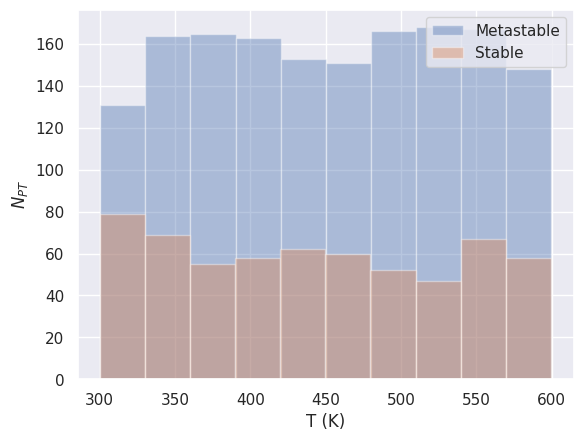

In [9]:
n, bins, patches = plt.hist(unstable_transition_phases['transition-temperature'], alpha=0.4, label='Metastable')
n, bins, patches = plt.hist(stable_transition_phases['transition-temperature'],   alpha=0.4, label='Stable')

plt.legend(loc='best')
plt.xlabel('T (K)')
plt.ylabel(r'$N_{PT}$')
plt.savefig(f'{output_folder}/histogram_critical_temperatures.eps', dpi=50, bbox_inches='tight')
plt.show()

## Amount of phase transitions involving some entropy change

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


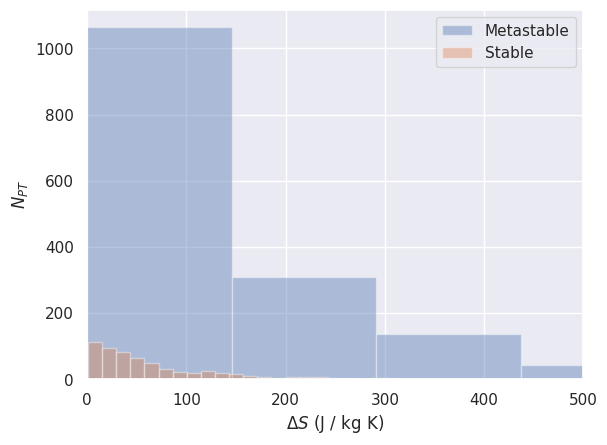

In [10]:
n, bins, patches = plt.hist(unstable_transition_phases['entropy-change'], bins=100, alpha=0.4, label='Metastable')
n, bins, patches = plt.hist(stable_transition_phases['entropy-change'],   bins=100, alpha=0.4, label='Stable')

plt.legend(loc='best')
plt.xlim(0, 500)
plt.xlabel(r'$\Delta S$ (J / kg K)')
plt.ylabel(r'$N_{PT}$')
plt.savefig(f'{output_folder}/histogram_entropy_changes.eps', dpi=50, bbox_inches='tight')
plt.show()

## Amount of phase transitions in terms of centrosymmetry

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


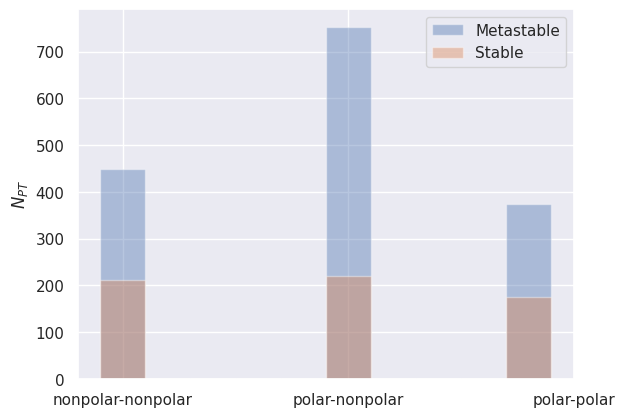

In [11]:
# Swith to type of transition
plt_unstable_non_centrosymmetry = np.array(unstable_transition_phases['centrosymmetry'], dtype=object)
plt_stable_non_centrosymmetry   = np.array(stable_transition_phases['centrosymmetry'],   dtype=object)

centrosymmetries = np.array(['polar-polar', 'polar-nonpolar', 'nonpolar-nonpolar'])

for i in range(len(centrosymmetries)):
    plt_unstable_non_centrosymmetry[np.where(unstable_transition_phases['centrosymmetry'] == i)[0]] = centrosymmetries[i]
    plt_stable_non_centrosymmetry[np.where(stable_transition_phases['centrosymmetry']     == i)[0]] = centrosymmetries[i]

# Create the histogram

n, bins, patches = plt.hist(plt_unstable_non_centrosymmetry, alpha=0.4, label='Metastable', align='left')
n, bins, patches = plt.hist(plt_stable_non_centrosymmetry,   alpha=0.4, label='Stable', align='left')

plt.ylabel(r'$N_{PT}$')
plt.legend(loc='best')
plt.savefig(f'{output_folder}/histogram_centrosymmetry.eps', dpi=50, bbox_inches='tight')
plt.show()

## Amount of phase transitions at each temperature and LTC change

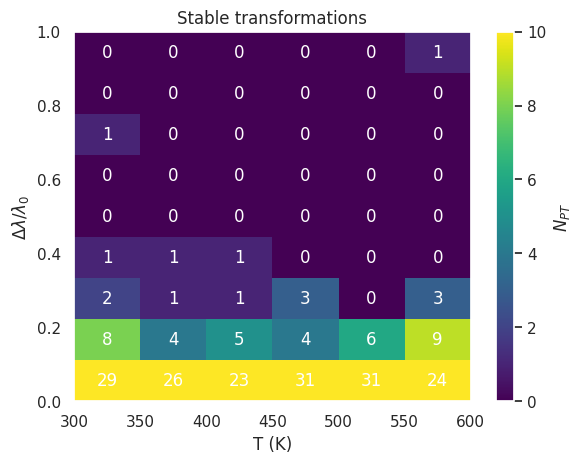

In [12]:
x_edges = temperatures
y_edges = np.linspace(0, 1, 10)

# Generate the 2D histogram data
distribution = np.histogram2d(stable_transition_phases['transition-temperature'], stable_transition_phases['conductivity-change'],
                              bins=(list(x_edges), list(y_edges))
                             )[0].T

# Create meshgrid for plotting
X, Y = np.meshgrid(x_edges, y_edges)

# Plot the 2D histogram with pcolormesh
fig, ax = plt.subplots()
plt.pcolormesh(X, Y, distribution, shading='auto', cmap='viridis', vmin=0, vmax=10)
plt.xlabel('T (K)')
plt.ylabel(r'$\Delta \lambda / \lambda_0$')

# Calculate the centers of each cell
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2
X_centers, Y_centers = np.meshgrid(x_centers, y_centers)

# Flatten the centers and Z values for vectorized annotation
x_flat = X_centers.flatten()
y_flat = Y_centers.flatten()
z_flat = distribution.flatten()

# Annotate all cells at once using vectorized operations
for xc, yc, z in zip(x_flat, y_flat, z_flat):
    ax.text(xc, yc, f'{int(z)}', ha='center', va='center', color='white')

# Add colorbar
colorbar = plt.colorbar()
colorbar.set_label(r'$N_{PT}$')

# Save the plot to a file
plt.title('Stable transformations')
plt.savefig(f'{output_folder}/temperature_vs_stable_conductivity_changes.pdf', dpi=50, bbox_inches='tight')
plt.show()

## Amount of phase transitions at each temperature and entropy change

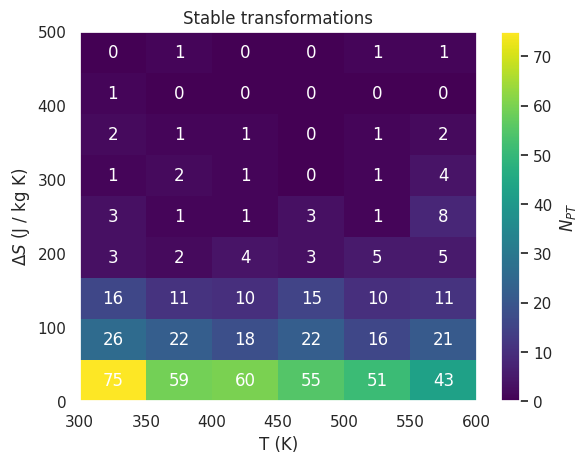

In [13]:
x_edges = temperatures
y_edges = np.linspace(0, 500, 10)

# Generate the 2D histogram data
distribution = np.histogram2d(stable_transition_phases['transition-temperature'], stable_transition_phases['entropy-change'],
                              bins=(list(x_edges), list(y_edges))
                             )[0].T

# Create meshgrid for plotting
X, Y = np.meshgrid(x_edges, y_edges)

# Plot the 2D histogram with pcolormesh
fig, ax = plt.subplots()
plt.pcolormesh(X, Y, distribution, shading='auto', cmap='viridis')
plt.xlabel('T (K)')
plt.ylabel(r'$\Delta S$ (J / kg K)')

# Calculate the centers of each cell
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2
X_centers, Y_centers = np.meshgrid(x_centers, y_centers)

# Flatten the centers and Z values for vectorized annotation
x_flat = X_centers.flatten()
y_flat = Y_centers.flatten()
z_flat = distribution.flatten()

# Annotate all cells at once using vectorized operations
for xc, yc, z in zip(x_flat, y_flat, z_flat):
    ax.text(xc, yc, f'{int(z)}', ha='center', va='center', color='white')

# Add colorbar
colorbar = plt.colorbar()
colorbar.set_label(r'$N_{PT}$')

# Save the plot to a file
plt.title('Stable transformations')
plt.savefig(f'{output_folder}/temperature_vs_stable_entropy_changes.pdf', dpi=50, bbox_inches='tight')
plt.show()

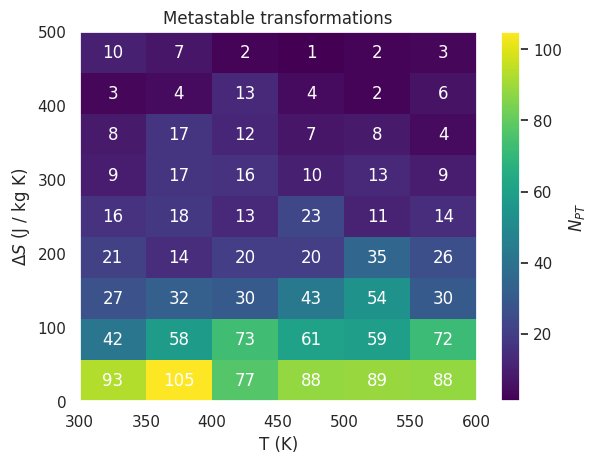

In [14]:
x_edges = temperatures
y_edges = np.linspace(0, 500, 10)

# Generate the 2D histogram data
distribution = np.histogram2d(unstable_transition_phases['transition-temperature'], unstable_transition_phases['entropy-change'],
                              bins=(list(x_edges), list(y_edges))
                             )[0].T

# Create meshgrid for plotting
X, Y = np.meshgrid(x_edges, y_edges)

# Plot the 2D histogram with pcolormesh
fig, ax = plt.subplots()
plt.pcolormesh(X, Y, distribution, shading='auto', cmap='viridis')
plt.xlabel('T (K)')
plt.ylabel(r'$\Delta S$ (J / kg K)')

# Calculate the centers of each cell
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2
X_centers, Y_centers = np.meshgrid(x_centers, y_centers)

# Flatten the centers and Z values for vectorized annotation
x_flat = X_centers.flatten()
y_flat = Y_centers.flatten()
z_flat = distribution.flatten()

# Annotate all cells at once using vectorized operations
for xc, yc, z in zip(x_flat, y_flat, z_flat):
    ax.text(xc, yc, f'{int(z)}', ha='center', va='center', color='white')

# Add colorbar
colorbar = plt.colorbar()
colorbar.set_label(r'$N_{PT}$')

# Save the plot to a file
plt.title('Metastable transformations')
plt.savefig(f'{output_folder}/temperature_vs_unstable_stable_entropy_changes.pdf', dpi=50, bbox_inches='tight')
plt.show()

## Amount of phase transitions at each temperature and centrosymmetries

In [15]:
# Create a mapping of strings to unique integers
centrosymmetries_dict = {'polar-polar':       0,
                         'polar-nonpolar':    1,
                         'nonpolar-nonpolar': 2}
centrosymmetry_edges = [0, 0.66, 1.33, 2]
centrosymmetry_ticks_x = [0.33, 1, 1.66]
centrosymmetry_ticks_labels = ['polar-polar', 'polar-nonpolar', 'nonpolar-nonpolar']

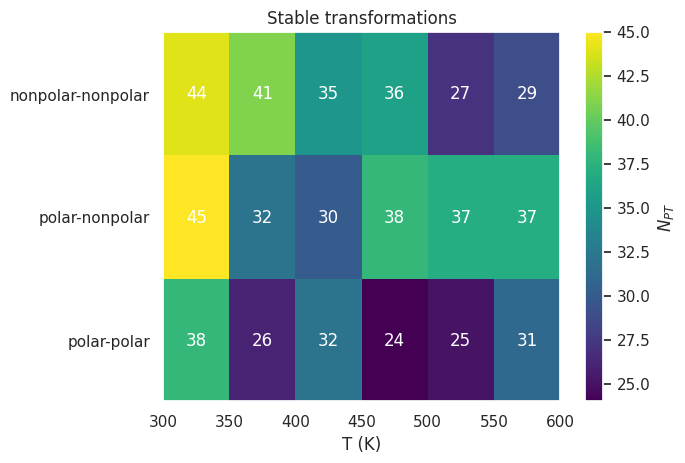

In [16]:
x_edges = temperatures
y_edges = np.array(centrosymmetry_edges)

# Generate the 2D histogram data
distribution = np.histogram2d(stable_transition_phases['transition-temperature'], stable_transition_phases['centrosymmetry'],
                              bins=(list(x_edges), list(y_edges))
                             )[0].T

# Create meshgrid for plotting
X, Y = np.meshgrid(x_edges, y_edges)

# Plot the 2D histogram with pcolormesh
fig, ax = plt.subplots()
plt.pcolormesh(X, Y, distribution, shading='auto', cmap='viridis')
plt.yticks(centrosymmetry_ticks_x,
           centrosymmetry_ticks_labels)
plt.xlabel('T (K)')

# Calculate the centers of each cell
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2
X_centers, Y_centers = np.meshgrid(x_centers, y_centers)

# Flatten the centers and Z values for vectorized annotation
x_flat = X_centers.flatten()
y_flat = Y_centers.flatten()
z_flat = distribution.flatten()

# Annotate all cells at once using vectorized operations
for xc, yc, z in zip(x_flat, y_flat, z_flat):
    ax.text(xc, yc, f'{int(z)}', ha='center', va='center', color='white')

# Add colorbar
colorbar = plt.colorbar()
colorbar.set_label(r'$N_{PT}$')

# Save the plot to a file
plt.title('Stable transformations')
plt.savefig(f'{output_folder}/temperature_vs_stable_centrosymmetry.pdf', dpi=50, bbox_inches='tight')
plt.show()

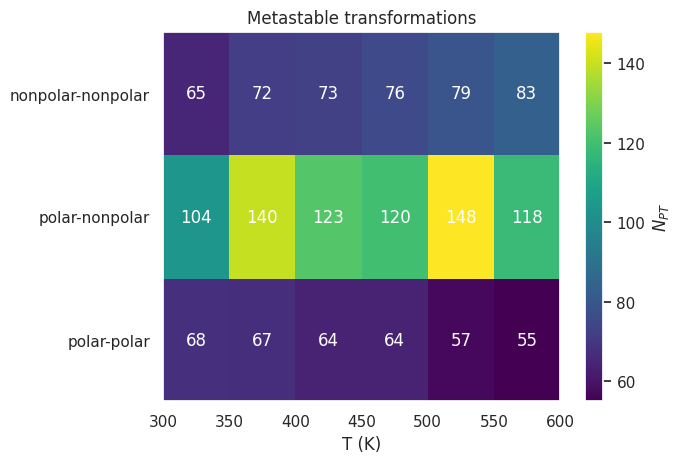

In [17]:
x_edges = temperatures
y_edges = np.array(centrosymmetry_edges)

# Generate the 2D histogram data
distribution = np.histogram2d(unstable_transition_phases['transition-temperature'], unstable_transition_phases['centrosymmetry'],
                              bins=(list(x_edges), list(y_edges))
                             )[0].T

# Create meshgrid for plotting
X, Y = np.meshgrid(x_edges, y_edges)

# Plot the 2D histogram with pcolormesh
fig, ax = plt.subplots()
plt.pcolormesh(X, Y, distribution, shading='auto', cmap='viridis')
plt.yticks(centrosymmetry_ticks_x,
           centrosymmetry_ticks_labels)
plt.xlabel('T (K)')

# Calculate the centers of each cell
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2
X_centers, Y_centers = np.meshgrid(x_centers, y_centers)

# Flatten the centers and Z values for vectorized annotation
x_flat = X_centers.flatten()
y_flat = Y_centers.flatten()
z_flat = distribution.flatten()

# Annotate all cells at once using vectorized operations
for xc, yc, z in zip(x_flat, y_flat, z_flat):
    ax.text(xc, yc, f'{int(z)}', ha='center', va='center', color='white')

# Add colorbar
colorbar = plt.colorbar()
colorbar.set_label(r'$N_{PT}$')

# Save the plot to a file
plt.title('Metastable transformations')
plt.savefig(f'{output_folder}/temperature_vs_unstable_centrosymmetry.pdf', dpi=50, bbox_inches='tight')
plt.show()

## Amount of phase transitions with centrosymmetries and entropy change

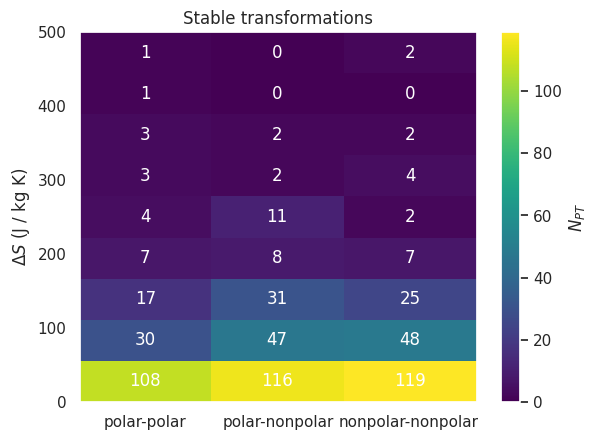

In [18]:
x_edges = np.array(centrosymmetry_edges)
y_edges = np.linspace(0, 500, 10)

# Generate the 2D histogram data
distribution = np.histogram2d(stable_transition_phases['centrosymmetry'], stable_transition_phases['entropy-change'],
                              bins=(list(x_edges), list(y_edges))
                             )[0].T

# Create meshgrid for plotting
X, Y = np.meshgrid(x_edges, y_edges)

# Plot the 2D histogram with pcolormesh
fig, ax = plt.subplots()
plt.pcolormesh(X, Y, distribution, shading='auto', cmap='viridis')
plt.xticks(centrosymmetry_ticks_x,
           centrosymmetry_ticks_labels)
plt.ylabel(r'$\Delta S$ (J / kg K)')

# Calculate the centers of each cell
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2
X_centers, Y_centers = np.meshgrid(x_centers, y_centers)

# Flatten the centers and Z values for vectorized annotation
x_flat = X_centers.flatten()
y_flat = Y_centers.flatten()
z_flat = distribution.flatten()

# Annotate all cells at once using vectorized operations
for xc, yc, z in zip(x_flat, y_flat, z_flat):
    ax.text(xc, yc, f'{int(z)}', ha='center', va='center', color='white')

# Add colorbar
colorbar = plt.colorbar()
colorbar.set_label(r'$N_{PT}$')

# Save the plot to a file
plt.title('Stable transformations')
plt.savefig(f'{output_folder}/entropy_changes_vs_stable_centrosymmetry.pdf', dpi=50, bbox_inches='tight')
plt.show()

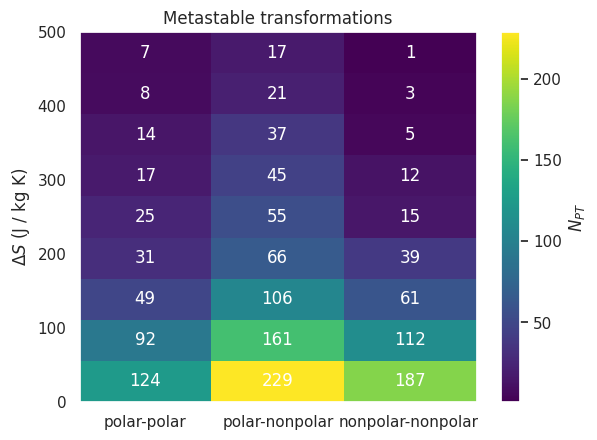

In [19]:
x_edges = np.array(centrosymmetry_edges)
y_edges = np.linspace(0, 500, 10)

# Generate the 2D histogram data
distribution = np.histogram2d(unstable_transition_phases['centrosymmetry'], unstable_transition_phases['entropy-change'],
                              bins=(list(x_edges), list(y_edges))
                             )[0].T

# Create meshgrid for plotting
X, Y = np.meshgrid(x_edges, y_edges)

# Plot the 2D histogram with pcolormesh
fig, ax = plt.subplots()
plt.pcolormesh(X, Y, distribution, shading='auto', cmap='viridis')
plt.xticks(centrosymmetry_ticks_x,
           centrosymmetry_ticks_labels)
plt.ylabel(r'$\Delta S$ (J / kg K)')

# Calculate the centers of each cell
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2
X_centers, Y_centers = np.meshgrid(x_centers, y_centers)

# Flatten the centers and Z values for vectorized annotation
x_flat = X_centers.flatten()
y_flat = Y_centers.flatten()
z_flat = distribution.flatten()

# Annotate all cells at once using vectorized operations
for xc, yc, z in zip(x_flat, y_flat, z_flat):
    ax.text(xc, yc, f'{int(z)}', ha='center', va='center', color='white')

# Add colorbar
colorbar = plt.colorbar()
colorbar.set_label(r'$N_{PT}$')

# Save the plot to a file
plt.title('Metastable transformations')
plt.savefig(f'{output_folder}/entropy_changes_vs_unstable_centrosymmetry.pdf', dpi=50, bbox_inches='tight')
plt.show()